In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from PIL import Image
from tensorflow.keras.preprocessing import image


In [2]:
from tensorflow.keras.models import load_model

# Define focal_loss_fixed function again if it is not already available
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        import tensorflow.keras.backend as K
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        focal_loss = -alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t + K.epsilon())
        return K.mean(focal_loss)
    return focal_loss_fixed

model = load_model("D:/PATENT/Model_testing/GEOM_ballooning10.h5", custom_objects={'focal_loss_fixed': focal_loss()})

In [3]:
for layer in model.layers:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [4]:
# Create a model for feature map extraction
feature_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_3_conv').output)

In [5]:
def extract_and_display_image(image_path, feature_model):
    img = Image.open(image_path)
    img_resized = img.resize((299, 299), Image.ANTIALIAS)
    img_array = np.array(img_resized) / 255.0
    img_array = img_array[np.newaxis, ...]

    # Display the original image
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Get the feature maps
    feature_maps = feature_model.predict(img_array)[0]
    return feature_maps

In [6]:
def visualize_feature_maps(feature_maps, num_features=15):
    # Display the first 'num_features' feature maps
    fig, axes = plt.subplots(nrows=int(np.sqrt(num_features)), ncols=int(np.sqrt(num_features)), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_features:
            ax.imshow(feature_maps[:, :, i], cmap='viridis')
            ax.axis('off')
    plt.show()

In [7]:
def predict_and_display(image_path, model):
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array /= 255.0  # Normalize the image
    prediction = model.predict(img_array)

    # Display the processed image
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted: {"Ballooning Present" if prediction[0][0] > 0.5 else "Ballooning Absent"}')
    plt.show()

    return prediction

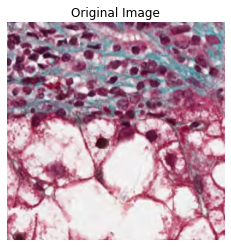

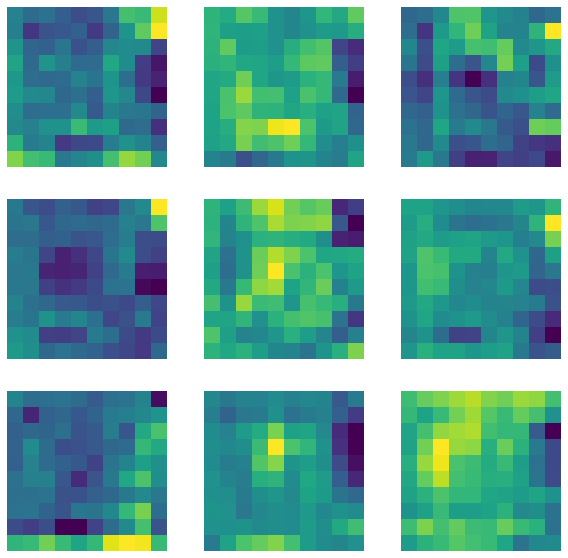

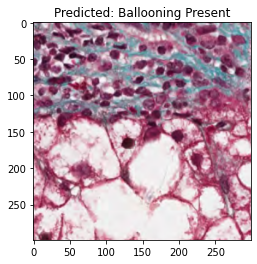

Probability of prediction=  [[0.7118164]]


In [10]:
image_path = "D:/DATASET/CNN/ballooning/train/1/405_276_76.png"
feature_maps = extract_and_display_image(image_path, feature_model)
visualize_feature_maps(feature_maps)
predicted_class=predict_and_display(image_path, model)
print("Probability of prediction= ",predicted_class)

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model

def crop_and_predict_large_image(image_path, model_path, crop_size=(299, 299), step_size=299):
    # Load the pre-trained model
    model = load_model(model_path)
    
    # Load the large image
    large_img = Image.open(image_path)
    large_img = large_img.resize((1853, 932))  # Ensure the image is correctly sized
    
    # Dimensions for cropping
    crop_width, crop_height = crop_size
    scores = []
    
    # Create a figure for displaying
    fig, axs = plt.subplots(nrows=(932 // crop_height), ncols=(1853 // crop_width), figsize=(20, 10))
    
    # Process each crop
    for i in range(0, 932 - crop_height + 1, step_size):
        for j in range(0, 1853 - crop_width + 1, step_size):
            # Crop the image
            crop = large_img.crop((j, i, j + crop_width, i + crop_height))
            crop_array = keras_image.img_to_array(crop)
            crop_array = np.expand_dims(crop_array, axis=0) / 255.0  # Normalize

            # Predict the ballooning score
            prediction = model.predict(crop_array)
            predicted_score = np.argmax(prediction)
            scores.append(predicted_score)
            
            # Plot each crop
            ax = axs[i // crop_height, j // crop_width]
            ax.imshow(crop)
            ax.title.set_text(f'Score: {predicted_score}')
            ax.axis('off')

    # Calculate the average score
    average_score = np.mean(scores)
    print(f'Average Ballooning Score for the large image: {average_score:.2f}')
    
    # Display the entire large image with the final score
    plt.figure(figsize=(10, 5))
    plt.imshow(large_img)
    plt.title(f'Final Ballooning Score: {average_score:.2f}')
    plt.axis('off')
    plt.show()
    
    return average_score


In [ ]:
model_path = 'D:/DATASET/Models/model_ballooning.h5'
image_path = "D:/scoring/Z_n-esh40x2.jpg"
average_ballooning_score = crop_and_predict_large_image(image_path, model_path)